In [247]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib
import PIL
import PIL.Image
from matplotlib import pyplot as plt

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Checking image dataset count

In [248]:
# Image dataset count 
data_dir_str = "C:\\Users\\me1kox\\Scratch Space\\carpet_ed"
data_dir = pathlib.Path(data_dir_str)
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


397


# Extracting necessary input shape from dataset

In [249]:
IMG_SIZE = (224,224)

In [250]:
from  PIL import Image
img = Image.open(data_dir_str + "\\good\\a (1).png")
img = img.resize(IMG_SIZE)
img = np.asarray(img)
image_height = img.shape[0]
image_width = img.shape[1]
img_batch = tf.expand_dims(img, axis=0)
img_batch.shape.as_list()

[1, 224, 224, 3]

# Setting Backbone

In [251]:
backbone = tf.keras.applications.ResNet50(input_shape=img.shape,
                                       include_top=False,
                                       weights='imagenet',
                                       )

backbone.summary()
# tf.keras.utils.plot_model(backbone, to_file= ".\\backbone.png", show_shapes=True, show_layer_names = True)

# backbone.layers[1]

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# Implementing FCN architecture

In [252]:
print(backbone.layers[27].name)

conv2_block2_add


In [253]:
# import copy

# layers_to_include = 1 # Controls number of layers to be used as backbone of FCDD

# def create_model():
#     global backbone
#     global layers_to_include
    
#     input_layer = tf.keras.layers.Input(shape=(img.shape), name="Input Layer")
#     x =  backbone.layers[1](input_layer)
#     layer_marker =  2
    
#     # for loop_idx in range (layers_to_include):
#     #     if loop_idx > 0:
#     #         x = backbone.layers[layer_marker](x)        
#     #         layer_marker += 1
#     #     while not("add" in backbone.layers[layer_marker].name): 
#     #         x = backbone.layers[layer_marker](x)
#     #         # x = tf.keras.layers.BatchNormalization()(x)
#     #         layer_marker += 1
#     #     x = backbone.layers[layer_marker](x.)
#     #     x = backbone.layers[layer_marker+1](x)
    
#     for index in range(5):
#         x = backbone.layers[layer_marker](x)        
#         layer_marker += 1
        
#     x1 = copy.deepcopy(x)
#     x2 = copy.deepcopy(x)
    
#     for index in range(8):
#         x1 = backbone.layers[layer_marker](x1)
#         layer_marker += 1
        
#     for index in range(2):
#         x2 = backbone.layers[layer_marker](x2)
#         layer_marker += 1 
        
#     layer_marker += 1
#     x3 = backbone.layers[layer_marker]([x1,x2])
        
               

#     x3 = tf.keras.layers.Conv2D(filters=1,
#                             kernel_size=(1,1), 
#                             strides=(1,1),
#                             padding="same",
#                             activation="relu"
#                             )(x3)

#     model = tf.keras.models.Model(inputs=input_layer, outputs=x3)
    
   

    
        
#     return model
#     # model.layers[1].name
    
# model = create_model()
# last_layer_shape = model.layers[-1].output_shape
# model.summary()
# tf.keras.utils.plot_model(model, to_file= ".\\model.png", show_shapes=True)


Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['Input Layer[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[1][0]']              
                                )                                                                 
                                                                                           

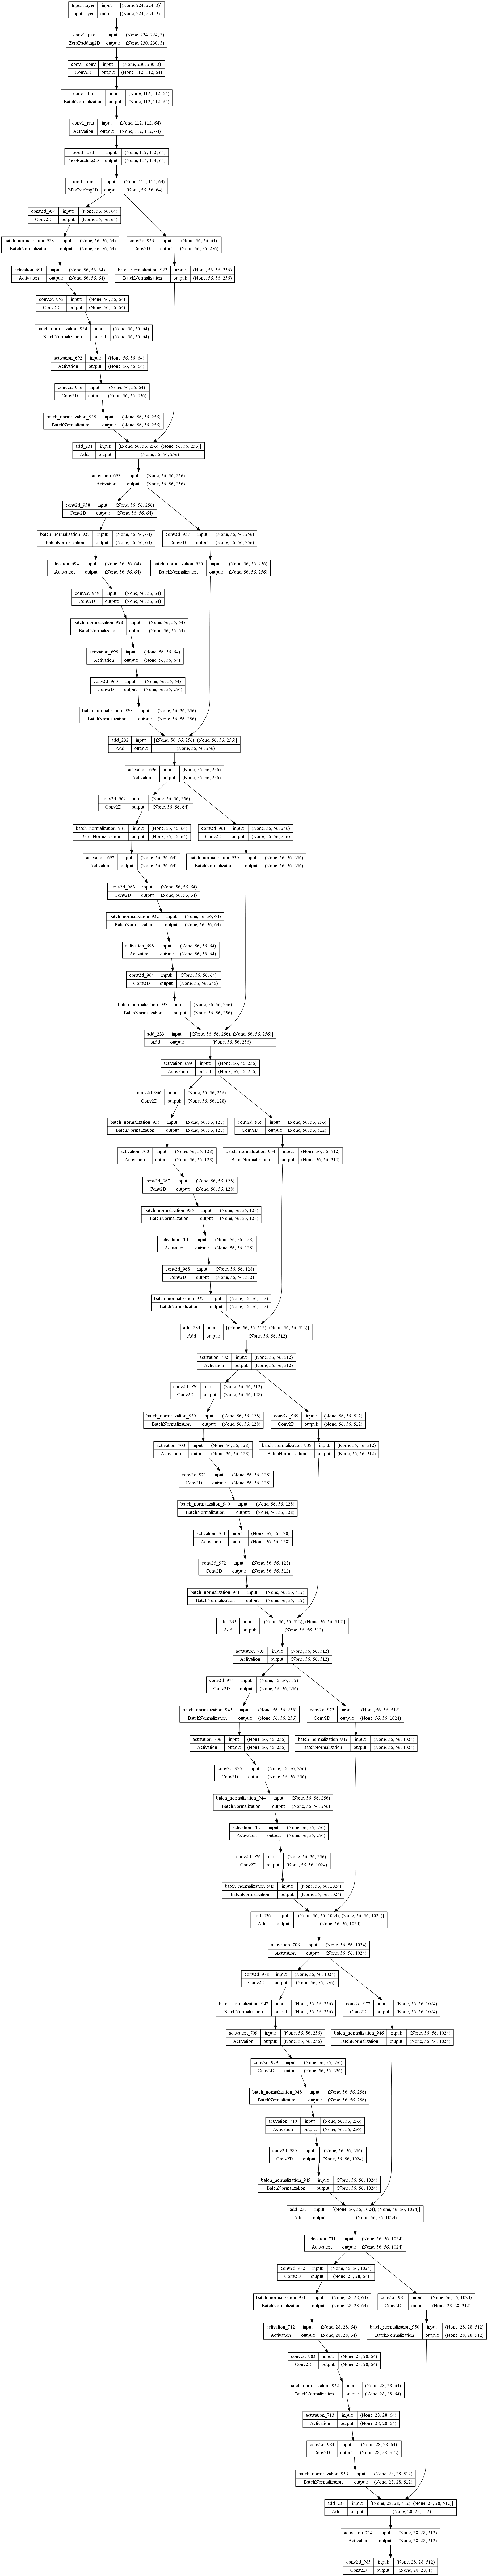

In [254]:
number_of_res_blocks = 3

def bottleneck_residual_block(X, kernel_size, filters, reduce=False, stride=2):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    if reduce:
        X_shortcut = tf.keras.layers.Conv2D(filters = F3, kernel_size = (1, 1), strides =
        (stride,stride))(X_shortcut)
        X_shortcut = tf.keras.layers.BatchNormalization(axis = -1)(X_shortcut)
        X = tf.keras.layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (stride,stride), padding ='valid')(X)
        X = tf.keras.layers.BatchNormalization(axis = -1)(X)
        X = tf.keras.layers.Activation('relu')(X)
    else:
        # First component of main path
        X = tf.keras.layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
        X = tf.keras.layers.BatchNormalization(axis = 3)(X)
        X = tf.keras.layers.Activation('relu')(X)
        
    # Second component of main path
    X = tf.keras.layers.Conv2D(filters = F2, kernel_size = kernel_size, strides = (1,1), padding = 'same')(X)
    X = tf.keras.layers.BatchNormalization(axis = -1)(X)
    X = tf.keras.layers.Activation('relu')(X)
    # Third component of main path
    X = tf.keras.layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding ='valid')(X)
    X = tf.keras.layers.BatchNormalization(axis = -1)(X)
    # Final step
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    return X

def create_model():
    global backbone
    global number_of_res_blocks
    
    input_layer = tf.keras.layers.Input(shape=(img.shape), name="Input Layer")
    x =  backbone.layers[1](input_layer)
    layer_marker = 2
    
    for index in range(5):
        x = backbone.layers[layer_marker](x)        
        layer_marker += 1
        
        
    for index in range(3):
        x = bottleneck_residual_block(x, 3, (64, 64, 256),reduce=True, stride=1)
        
    for index in range(2):
        x = bottleneck_residual_block(x, 3, (128, 128, 512),reduce=True, stride=1)
        
    # x = bottleneck_residual_block(x, 3, (64, 64, 128),reduce=True, stride=2)
    
    for index in range(2):
        x = bottleneck_residual_block(x, 3, (256, 256, 1024),reduce=True, stride=1)
    
    x = bottleneck_residual_block(x, 3, (64, 64, 512),reduce=True, stride=2)
        
    x = tf.keras.layers.Conv2D(filters=1,
                            kernel_size=(1,1), 
                            strides=(1,1),
                            padding="same",
                            activation="relu"
                            )(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
        
    return model

model = create_model()
last_layer_shape = model.layers[-1].output_shape
model.summary()
tf.keras.utils.plot_model(model, to_file= ".\\model.png", show_shapes=True)

# Testing FCN network forward pass

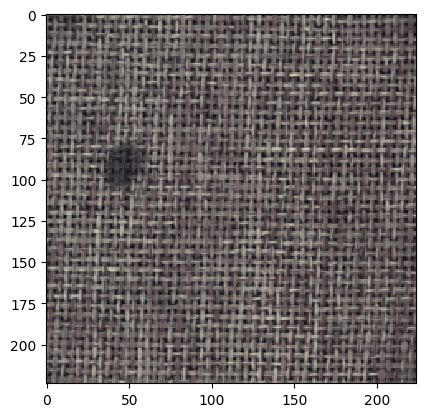

In [255]:
test_img = PIL.Image.open("C:\\Users\\me1kox\\Scratch Space\\carpet_ed\\anomalous\\a (5).png")
test_img = test_img.resize(IMG_SIZE)
test_img = np.array(test_img)*(1./255)

plt.imshow(test_img, interpolation='nearest')
plt.show()

# test_input = tf.random.uniform(shape = (224, 224, 3),
#                                minval= 0,
#                                maxval= 1,
#                                dtype= tf.dtypes.float32
#                                )

# test_input_batch = tf.expand_dims(test_input, axis=0)
test_input_batch = tf.expand_dims(test_img, axis=0)

test_network_output = model(test_input_batch)

# Defining custom loss function

In [256]:
class HSC_loss_custom(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        
    def call(self, y_true, network_output_tensor):
        # activation_squared = tf.math.square(network_output_tensor)
        # activation_squared_plus_one = tf.math.add(activation_squared, 1.0)
        # activation_squared_plus_one_sqrt = tf.math.sqrt(activation_squared_plus_one)
        # activation_squared_plus_one_sqrt_minus_one = tf.math.subtract(activation_squared_plus_one_sqrt, 1.0)
               
        pseudo_huber_loss = (tf.math.sqrt(tf.math.add(tf.math.square(network_output_tensor), 1.0))) - tf.convert_to_tensor(1.0)
        sum_of_huber_elements = tf.reduce_sum(pseudo_huber_loss, axis=(1,2))
        # proto_tensor = tf.make_tensor_proto(sum_of_huber_elements)
        # sum_of_huber_elements = tf.make_ndarray(proto_tensor)
        
        denominator = float(last_layer_shape[1]*last_layer_shape[2])
        # denominator = (2*2)

        
        hsc_loss_first_term = (1.0-y_true)*(1.0/denominator)*sum_of_huber_elements
        hsc_loss_second_term = y_true*tf.math.log(1-tf.math.exp(-1 * (sum_of_huber_elements/denominator)))
        
        hsc_loss = tf.math.subtract(hsc_loss_first_term,hsc_loss_second_term)
        # print(hsc_loss.numpy())
        
        return hsc_loss
            
        

# Testing custom loss function

In [257]:
y_true = tf.constant(1.0, shape=(1,1))

# network_output_sample = tf.random.uniform(
#                                 shape = (32,28, 28, 1),
#                                 minval= 0,
#                                 maxval= 1,
#                                 dtype= tf.dtypes.float32
#                                )

test_loss = HSC_loss_custom()(y_true, test_network_output)
print(test_loss.numpy())

KeyboardInterrupt: 

# Prepare image dataset

In [235]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # horizontal_flip=True,
    # vertical_flip=True
)

train_ds = img_gen.flow_from_directory(data_dir_str+"//training_ds",
                                       target_size= IMG_SIZE,
                                       batch_size=32, 
                                       shuffle=False, 
                                       class_mode='sparse')

train_ds.classes

# img_sample, label = train_ds.next()
# plt.imshow(img_sample[0])
# plt.show()

Found 368 images belonging to 2 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Training the FCN network

In [237]:
optimizer_custom = tf.keras.optimizers.experimental.SGD(
                                    learning_rate=0.001,
                                    momentum=0.9,
                                    nesterov=False,                                    
                                    name="SGD"
)

model.compile(optimizer=optimizer_custom, 
              loss= HSC_loss_custom(), 
            #   run_eagerly=True,
              metrics=[]
              )

In [238]:
import scipy.integrate
import scipy.special
import datetime

# Load the TensorBoard notebook extension
%load_ext tensorboard

# def scheduler(epoch, lr):
#     return lr * 0.985

# lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=5, min_lr=0.0000001)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(train_ds, epochs=200, callbacks=[reduce_lr, tensorboard_callback])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/200
12/12 [==============================] - 24s 1s/step - loss: 0.5072 - lr: 0.0010
Epoch 2/200
12/12 [==============================] - 15s 1s/step - loss: 0.4754 - lr: 0.0010
Epoch 3/200
12/12 [==============================] - 15s 1s/step - loss: 0.5086 - lr: 0.0010
Epoch 4/200
12/12 [==============================] - 14s 1s/step - loss: 0.4969 - lr: 0.0010
Epoch 5/200
12/12 [==============================] - 14s 1s/step - loss: 0.5858 - lr: 0.0010
Epoch 6/200
12/12 [==============================] - 14s 1s/step - loss: 0.6068 - lr: 0.0010
Epoch 7/200
12/12 [==============================] - 15s 1s/step - loss: 0.4875 - lr: 0.0010
Epoch 8/200
12/12 [==============================] - 15s 1s/step - loss: 0.4996 - lr: 5.0000e-04
Epoch 9/200
12/12 [==============================] - 15s 1s/step - loss: 0.4316 - lr: 5.0000e-04
Epoch 10/200
12/12 [==============================] - 15s 1s/step

In [ ]:
%tensorboard --logdir logs/fit

# Saving model

In [239]:
model.save("fcdd_resnet50v3.h5")
model.save_weights("fcdd_resnet50v3_weights")

# Loading saved model

In [240]:
loaded_model = create_model()
loaded_model.load_weights("fcdd_resnet50v3_weights")

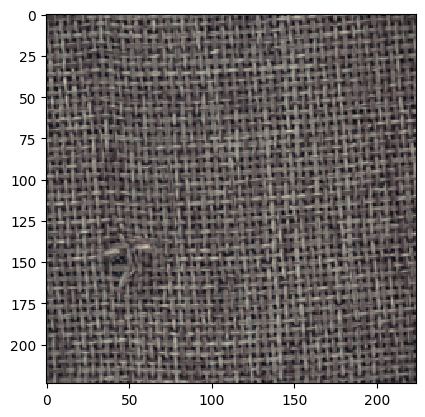

In [245]:
test_img = PIL.Image.open("C:\\Users\\me1kox\\Scratch Space\\carpet_ed\\anomalous\\c (6).png")
test_img = test_img.resize(IMG_SIZE)
test_img = np.array(test_img)*(1./255)

plt.imshow(test_img, interpolation='nearest')
plt.show()

test_img_batch = np.expand_dims(test_img, axis=0)

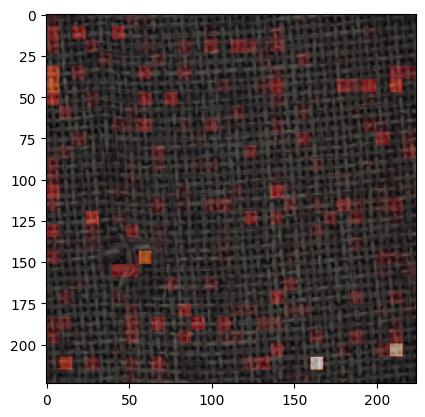

In [246]:
trained_FCN_output = loaded_model(test_img_batch)
defect_color_map = PIL.Image.fromarray(np.squeeze(trained_FCN_output, axis = (0,3)))
defect_color_map = defect_color_map.resize(size=IMG_SIZE, resample=PIL.Image.Resampling.NEAREST)
defect_color_map = np.array(defect_color_map)

plt.imshow(test_img)
plt.imshow(defect_color_map, alpha=0.5, cmap='gist_heat')
plt.show()